# 🚀 Datathon - Engenharia de Machine Learning: Case Passos Mágicos
**Autor:** [Seu Nome/Grupo]
**Data:** Janeiro/2026

## 🎯 Objetivo do Projeto
Desenvolver um **Sistema de Alerta Precoce** para identificar alunos da ONG Passos Mágicos com alto risco de piora na defasagem escolar.

## 🧠 Estratégia da Solução
Diferente de uma abordagem tradicional de apenas prever notas, focamos na **prevenção**.
1. **Target (Alvo):** Identificar alunos que *pioraram* sua defasagem de um ano para o outro.
2. **Features (Variáveis):** Utilizamos dados históricos, psicossociais e de engajamento para entender o contexto do aluno, não apenas sua nota de prova.
3. **Engenharia:** Criação de variáveis contextuais como `Tempo_Casa` e `Fase_Escolar`.

### 1. Configuração e Carregamento dos Dados
Nesta etapa, importamos as bibliotecas essenciais e carregamos o dataset.
* **Organização:** Os dados brutos estão na pasta `data/`, separada do código para segurança e organização (`Clean Code`).
* **Estrutura:** O arquivo Excel contém 3 abas (2022, 2023, 2024), permitindo uma análise longitudinal (evolução do aluno no tempo).

In [51]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [52]:
arquivo_excel = os.path.join("..", "data", "BASE DE DADOS PEDE 2024 - DATATHON.xlsx")

try:
    print(f"Buscando arquivo em: {os.path.abspath(arquivo_excel)}")
    
    # 1. Carregar o arquivo Excel
    xls = pd.ExcelFile(arquivo_excel)
    
    # 2. Imprimir os nomes das abas para conferência
    print("Abas encontradas:", xls.sheet_names)

    # 3. Carregamento das Abas 
    df_2022 = pd.read_excel(xls, sheet_name="PEDE2022")
    df_2023 = pd.read_excel(xls, sheet_name="PEDE2023")
    df_2024 = pd.read_excel(xls, sheet_name="PEDE2024")

    print("\nSucesso! Dados carregados.")
    print(f"2022: {df_2022.shape[0]} linhas")
    print(f"2023: {df_2023.shape[0]} linhas")
    print(f"2024: {df_2024.shape[0]} linhas")

except FileNotFoundError:
    print(f"\nERRO CRÍTICO: O arquivo não foi encontrado no caminho: {arquivo_excel}")
    print("Verifique se a estrutura de pastas é: Projeto -> data -> arquivo.xlsx")
except ValueError as e:
    print(f"\nERRO DE NOME DE ABA: {e}")
    print("Copie EXATAMENTE os nomes que apareceram em 'Abas encontradas' e cole no código.")

Buscando arquivo em: c:\Users\T-GAMER\Desktop\Python\Fase 5\data\BASE DE DADOS PEDE 2024 - DATATHON.xlsx
Abas encontradas: ['PEDE2022', 'PEDE2023', 'PEDE2024']

Sucesso! Dados carregados.
2022: 860 linhas
2023: 1014 linhas
2024: 1156 linhas


### 2. Pré-processamento e Feature Engineering
Aqui transformamos dados brutos em inteligência para o modelo. Nossas hipóteses de negócio foram:

* **`Fase_Num` (Ordinal):** Transformamos as fases (Alfa, Fase 1...) em números. *Hipótese:* Alunos em fases iniciais podem ter comportamentos de risco diferentes de universitários.
* **`Tempo_Casa`:** Calculado como `2023 - Ano de Ingresso`. *Hipótese:* Alunos veteranos ("Crias da Passos") são mais resilientes e têm menor risco de queda.
* **`Escola_Publica`:** Variável binária para capturar o contexto socioeconômico da escola de origem.
* **`Delta_INDE`:** A variação da nota entre 2022 e 2023 para capturar a tendência (se o aluno já vinha caindo).

In [53]:
# 2. Funções Auxiliares de Limpeza
def limpar_pedra(x):
    """Transforma a classificação Pedra em números para o modelo entender."""
    mapa_pedra = {
        'Quartzo': 1, 
        'Ágata': 2, 
        'Ametista': 3, 
        'Topázio': 4
    }
    # Se não estiver no mapa (ex: NaN), retorna NaN ou um valor neutro
    return mapa_pedra.get(x, np.nan)

def limpar_fase(x):
    # Mapeia as fases para uma escala numérica ordenada
    if isinstance(x, str):
        x = x.upper().strip()
        if 'ALFA' in x: return 0
        if 'FASE 1' in x: return 1
        if 'FASE 2' in x: return 2
        if 'FASE 3' in x: return 3
        if 'FASE 4' in x: return 4
        if 'FASE 5' in x: return 5
        if 'FASE 6' in x: return 6
        if 'FASE 7' in x: return 7
        if 'FASE 8' in x: return 8
    return np.nan # Ou trate como achar melhor



# 📚 Dicionário de Variáveis do Modelo

Este documento detalha todos os campos utilizados no modelo final de **Risco de Defasagem**, explicando sua origem e a justificativa técnica para sua inclusão.

---

## 🎯 1. Variável Alvo (Target)
*O que o modelo tenta prever.*

| Variável | Origem (Aba) | Descrição e Justificativa |
| :--- | :--- | :--- |
| **`TARGET_RISCO`** | `PEDE 2024` + `PEDE 2023` | **Variável Binária (0 ou 1).**<br>Criada comparando a *Defasagem* do ano atual (2024) com o ano anterior (2023).<br>• **1 (Risco):** Se a defasagem piorou (ex: era 0 e foi para -1).<br>• **0 (Estável):** Se a defasagem se manteve ou melhorou.<br>**Por que usar?** É o objetivo central do projeto: antecipar quem vai cair de rendimento. |

---

## 🧠 2. Features Selecionadas (Entrada do Modelo)
*As variáveis que o modelo usa para tomar a decisão (X).*

### 🏫 Contexto e Perfil
| Variável | Origem | Descrição e Justificativa |
| :--- | :--- | :--- |
| **`Fase_Num`** | `PEDE 2023` (Engenharia) | **Numérica (0-8).**<br>Transformação da coluna `Fase` (Alfa, Fase 1...).<br>**Por que usar?** A análise mostrou que alunos nas fases iniciais (crianças) têm risco maior de oscilação do que universitários (Fase 8). |
| **`Tempo_Casa`** | `PEDE 2023` (Engenharia) | **Numérica (Anos).**<br>Cálculo: `2023 - Ano de Ingresso`.<br>**Por que usar?** Captura a "experiência" do aluno na ONG. Alunos veteranos tendem a ser mais resilientes a quedas. |
| **`Escola_Publica`** | `PEDE 2023` (Engenharia) | **Binária (0/1).**<br>Derivada de `Instituição de Ensino`.<br>**Por que usar?** Adiciona contexto socioeconômico, diferenciando alunos da rede pública daqueles com bolsas em escolas particulares. |
| **`Defasagem_2023`** | `PEDE 2023` | **Numérica (Inteiro).**<br>O nível de atraso escolar no ano anterior.<br>**Por que usar?** O passado é um forte preditor do futuro. Alunos que já estão "na corda bamba" (Defasagem=0) mostraram maior instabilidade. |

### 📊 Indicadores de Desempenho (Passos Mágicos)
| Variável | Origem | Descrição e Justificativa |
| :--- | :--- | :--- |
| **`IPP_2023`** | `PEDE 2023` | **Indicador Psicopedagógico.**<br>Avaliação do suporte psicopedagógico.<br>**Por que usar?** Provou ser uma das variáveis mais importantes. Alunos com bom suporte mental/pedagógico têm menor risco. |
| **`IPV_2023`** | `PEDE 2023` | **Indicador de Ponto de Virada.**<br>Mede a integração do aluno com os valores da ONG.<br>**Por que usar?** Correlação negativa com risco: alunos "vestindo a camisa" desistem menos. |
| **`IDA_2023`** | `PEDE 2023` | **Indicador de Aprendizagem.**<br>Média das notas (Português, Matemática, etc.).<br>**Por que usar?** Mede a capacidade técnica atual do aluno. |
| **`IEG_2023`** | `PEDE 2023` | **Indicador de Engajamento.**<br>Entrega de lições e participação.<br>**Por que usar?** Diferencia o aluno que tem dificuldade (IDA baixo) do aluno que desistiu de tentar (IEG baixo). |
| **`IPS_2023`** | `PEDE 2023` | **Indicador Psicossocial.**<br>Avaliação do contexto familiar e emocional.<br>**Por que usar?** Problemas em casa refletem diretamente no risco escolar. |
| **`IAA_2023`** | `PEDE 2023` | **Indicador de Autoavaliação.**<br>Como o aluno se vê.<br>**Por que usar?** Baixa auto estima pode ser um precursor de queda de rendimento. |

In [54]:
# --- 1. PREPARAÇÃO DOS DADOS AUXILIARES (Histórico e Alvo) ---

# Preparar 2022 (Histórico para comparação)
df_historico_2022 = df_2022[['RA', 'INDE 22']].copy()
df_historico_2022.columns = ['RA', 'INDE_2022']

# Preparar 2024 (Target/Resposta para treinar o modelo)
df_alvo_2024 = df_2024[['RA', 'Defasagem']].copy()
df_alvo_2024.columns = ['RA', 'Defasagem_2024']


# --- 2. ENGENHARIA DE FEATURES (Baseado em 2023) ---

# Selecionar apenas as colunas úteis de 2023
colunas_base_2023 = [
    'RA', 'IAA', 'IEG', 'IPS', 'IDA', 'IPP', 'IPV', 'IAN', 
    'Defasagem', 'Pedra 2023', 
    'Fase', 'Ano ingresso', 'Instituição de ensino'
]

df_2023_features = df_2023[colunas_base_2023].copy()

# Renomear para padrão de código (snake_case)
df_2023_features.columns = [
    'RA', 'IAA_2023', 'IEG_2023', 'IPS_2023', 'IDA_2023', 
    'IPP_2023', 'IPV_2023', 'IAN_2023', 'Defasagem_2023', 'Pedra_Original',
    'Fase_Original', 'Ano_Ingresso', 'Escola_Original'
]

# --- Transformações e Criação de Variáveis ---

# 1. Tratamento da Fase (Transformar texto em número ordenado)
df_2023_features['Fase_Num'] = df_2023_features['Fase_Original'].apply(limpar_fase)

# 2. Tempo de Casa (Veteranos vs Novatos)
df_2023_features['Tempo_Casa'] = 2023 - df_2023_features['Ano_Ingresso']

# 3. Escola Pública (Contexto Socioeconômico - Binário)
df_2023_features['Escola_Publica'] = df_2023_features['Escola_Original'].apply(
    lambda x: 1 if isinstance(x, str) and 'Pública' in x else 0
)

# 4. Pedra (Numérico)
df_2023_features['Pedra_Num'] = df_2023_features['Pedra_Original'].apply(limpar_pedra)


# --- 3. CONSOLIDAÇÃO DOS DADOS (MERGES) ---

# Passo A: Cruzar 2023 com Histórico 2022
# (Left Join: nem todos os alunos de 23 estavam em 22)
df_intermediario = pd.merge(df_2023_features, df_historico_2022, on='RA', how='left')

# Passo B: Calcular Delta INDE (Tendência)
# Precisamos do INDE_2023 original momentaneamente
df_inde_2023 = df_2023[['RA', 'INDE 2023']].rename(columns={'INDE 2023': 'INDE_2023'})
df_intermediario = pd.merge(df_intermediario, df_inde_2023, on='RA', how='left')

# Cálculo da variação (fillna(0) assume estabilidade para quem não tem histórico)
df_intermediario['Delta_INDE'] = (df_intermediario['INDE_2023'] - df_intermediario['INDE_2022']).fillna(0)

# Passo C: Cruzar com o Target 2024 (Inner Join)
# Só podemos treinar com alunos que temos a "resposta" (estão em 2024)
df_completo = pd.merge(df_intermediario, df_alvo_2024, on='RA', how='inner')

# Passo D: Criar a Variável Alvo Final (RISCO)
# Risco = 1 se a defasagem piorou (ficou menor/mais negativa) de um ano pro outro
df_completo['TARGET_RISCO'] = (
    df_completo['Defasagem_2024'] < df_completo['Defasagem_2023']
).astype(int)


# --- 4. SELEÇÃO FINAL PARA O MODELO ---

features_finais = [
    # Indicadores Comportamentais e Notas
    'IAA_2023', 'IEG_2023', 'IPS_2023', 'IDA_2023', 'IPP_2023', 'IPV_2023', 'IAN_2023',
    # Contexto do Aluno
    'Defasagem_2023', 'Pedra_Num', 'Fase_Num', 'Tempo_Casa', 'Escola_Publica',
    # Tendências
    'Delta_INDE', 
    # O que queremos prever
    'TARGET_RISCO'
]

# Criação do Dataset Limpo para Modelagem
df_dataset_modelagem = df_completo[features_finais].dropna()

print(f"Dataset pronto para modelagem: {df_dataset_modelagem.shape}")
df_dataset_modelagem.head()

Dataset pronto para modelagem: (537, 14)


,IAA_2023,IEG_2023,IPS_2023,IDA_2023,IPP_2023,IPV_2023,IAN_2023,Defasagem_2023,Pedra_Num,Fase_Num,Tempo_Casa,Escola_Publica,Delta_INDE,TARGET_RISCO
0,9.5,10.0,8.13,9.6,8.4375,8.920,10.0,0,4.0,0,0,1,0.0,1
1,8.5,9.1,8.14,8.9,7.5000,8.585,5.0,-1,4.0,0,0,1,0.0,1
2,0.0,7.6,3.14,6.3,5.9375,6.260,10.0,0,1.0,0,0,1,0.0,1
3,9.0,8.6,8.76,8.9,7.5000,8.415,10.0,0,4.0,0,0,1,0.0,1
4,10.0,9.5,8.76,7.1,7.1875,8.670,10.0,0,4.0,0,0,1,0.0,1


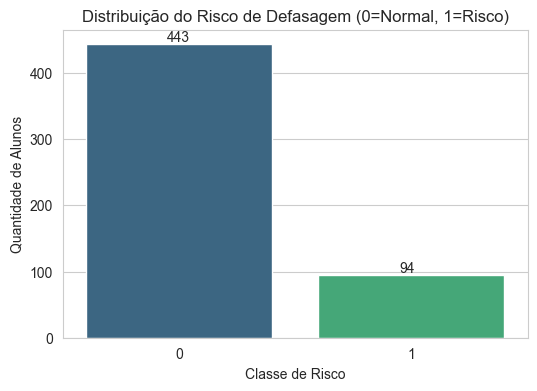

In [60]:
# 1. Configuração de Estilo
sns.set_style("whitegrid")

# 2. Verificar o Balanceamento do Target (Risco vs. Não Risco)
plt.figure(figsize=(6, 4))

# CORREÇÃO AQUI: Adicionamos hue='TARGET_RISCO' e legend=False
ax = sns.countplot(
    x='TARGET_RISCO', 
    data=df_dataset_modelagem, 
    hue='TARGET_RISCO', 
    palette='viridis', 
    legend=False
)

plt.title("Distribuição do Risco de Defasagem (0=Normal, 1=Risco)")
plt.xlabel("Classe de Risco")
plt.ylabel("Quantidade de Alunos")

# Adicionar rótulos nas barras
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + 0.35, p.get_height() + 5))

plt.show()

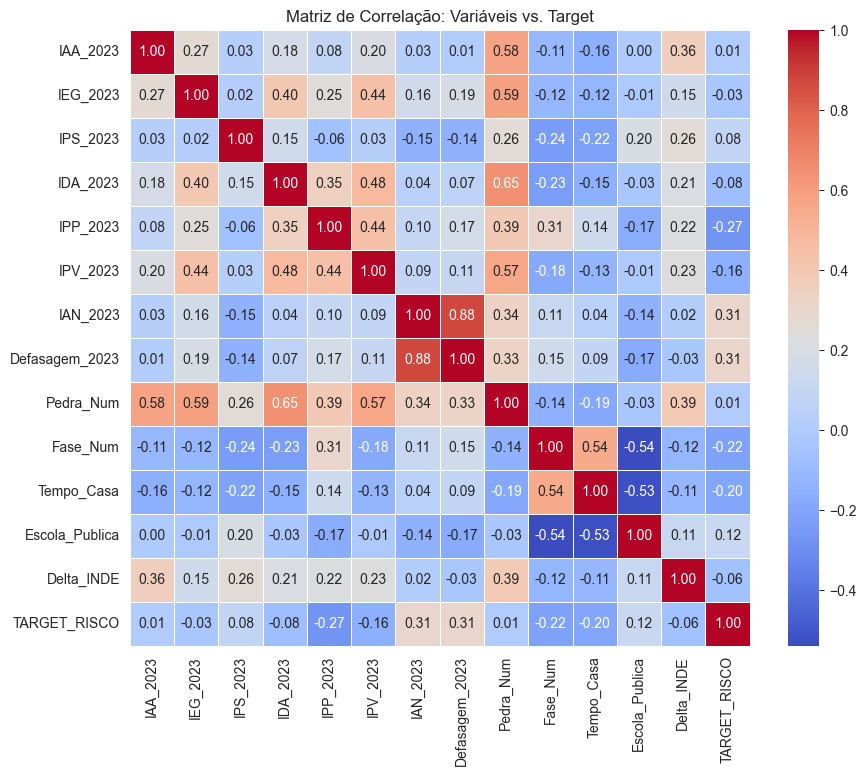

In [56]:
# 3. Matriz de Correlação (O que influencia o Risco?)
plt.figure(figsize=(10, 8))
# Calculando correlação apenas das colunas numéricas
corr = df_dataset_modelagem.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlação: Variáveis vs. Target")
plt.show()

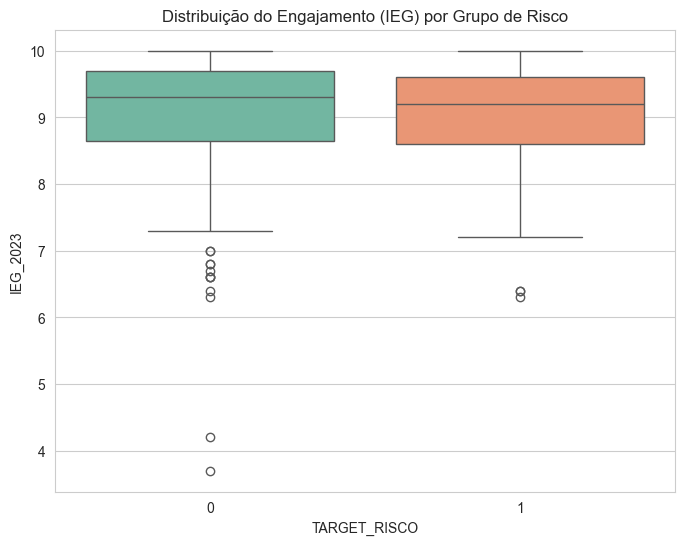

In [61]:
# 4. Boxplot: Engajamento (IEG) x Risco
# Hipótese: Quem tem risco (1) tende a ter notas menores de engajamento?
plt.figure(figsize=(8, 6))

# CORREÇÃO: Adicionado hue='TARGET_RISCO' e legend=False
sns.boxplot(
    x='TARGET_RISCO', 
    y='IEG_2023', 
    data=df_dataset_modelagem, 
    hue='TARGET_RISCO',      # Define quem controla a cor
    palette='Set2', 
    legend=False             # Remove a legenda duplicada
)

plt.title("Distribuição do Engajamento (IEG) por Grupo de Risco")
plt.show()

### 3. Seleção de Features (Data Cleaning)
Após a análise de correlação, removemos variáveis que não ajudam na predição:

* **`IAN_2023` (Removido):** Apresentou correlação de **0.86** com a `Defasagem`. Manter as duas causaria redundância (multicolinearidade), pois medem praticamente a mesma coisa.
* **`Pedra_Num` (Removido):** Teve correlação próxima de zero com o Risco. É uma métrica de "estado atual" e não provou ter poder preditivo para o futuro.
* **`Delta_INDE` (Removido):** Embora calculado, mostrou baixa importância na análise preliminar.

**Resultado:** Reduzimos de 14 para um conjunto menor de colunas focadas em **Comportamento** (`IEG`, `IPP`) e **Contexto** (`Fase`, `Tempo_Casa`).

In [ ]:
# --- 3. SELEÇÃO DE FEATURES (FEATURE SELECTION) ---
# Baseado na análise exploratória acima, decidimos remover variáveis redundantes ou com baixo poder preditivo.

print(f"Colunas antes da seleção: {df_dataset_modelagem.shape[1]}")

# Lista de colunas para remover
colunas_para_remover = [
    'IAN_2023',    # Motivo: Alta correlação (0.86) com a Defasagem. Redundante.
    'Pedra_Num',   # Motivo: Correlação próxima de zero com o Target.
    'Delta_INDE',  # Motivo: Baixa importância na Feature Importance preliminar.
    # Nota: Mantivemos Delta_IEG fora desde o início pois a análise mostrou correlação nula.
]

# Criando o Dataset Final "Enxuto"
df_final_treino = df_dataset_modelagem.drop(columns=colunas_para_remover, errors='ignore')

Colunas antes da seleção: 14


### ✅ Conclusão da Preparação
O dataset final (`df_final_treino`) está pronto para o modelo de Machine Learning.
Ele contém:
* **Target Balanceado:** Coluna `TARGET_RISCO` (0 ou 1).
* **Fatores Explicativos:** Notas, Engajamento e Contexto Social.
* **Limpeza:** Sem valores nulos e sem colunas redundantes.